In [17]:
# Ordinary Differential Equation Solver

import matplotlib.pyplot as plt
import numpy as np

def factorial(n):
    m = 1
    while (n!=0):
        m *= n
        n-= 1
    return m

def comb_cal(j):
    if(j == 0):
        return 1
    k = j
    vec_dict = {}
    while (k != 0):
        vec_dict[k] = np.zeros(k)
        k -= 1
    vec_dict[1][0] = 1
    if (j>1):
        for l in range(2,j+1):
            for k in range(1,l+1):
                #print(k,l)
                if(k==1):
                    vec_dict[l][k-1] = 1
                elif(k==l):
                    vec_dict[l][k-1] = (l-1)*vec_dict[l-1][k-2]
                else:
                    vec_dict[l][k-1] = vec_dict[l-1][k-1] + (l-1)*vec_dict[l-1][k-2] 
            #print("")
    return vec_dict[j]

def comb_cal2(j):
    if (j==0):
        return 1
    k = j+1
    vec_dict = {}
    while (k != 0):
        k -= 1
        vec_dict[k] = np.zeros(k+1)
    vec_dict[1][0] = 1
    if (j>0):
        for l in range(0,j+1): #1,2, (3(2+1)
            for k in range(0,l+1): #0,1...
                #print(k,l+1)
                if(k==0):
                    vec_dict[l][k] = 1
                elif(k==l):
                    if(k==1):
                        vec_dict[l][k] = (l-2)*vec_dict[l][k-1]
                    else:
                        vec_dict[l][k] = 0
                else:
                    if(l<=1):
                        vec_dict[l][k] = vec_dict[l][k] + (l-2)*vec_dict[l][k-1] 
                    else:    
                        vec_dict[l][k] = vec_dict[l-1][k] + (l-2)*vec_dict[l-1][k-1] 
            #print("")        
    return vec_dict[j]

# limit value for j <= 170
def gamma_cal(j):
    k = j
    l = k
    arr = comb_cal(k)
    if (k==0):
        return arr
    gamma = 0
    while(k!=0):
        gamma += arr[l-k]/(k+1)
        k -= 1
    gamma /= factorial(l)
    return gamma

def gamma_star_cal(j):
    k = j+1
    arr = comb_cal2(j)
    if (j==0):
        return arr
    gamma_star = 0
    while(k!=0):
        k -= 1
        gamma_star += arr[j-k]/(k+1)
    gamma_star /= factorial(j)
    return gamma_star

def nabla_func(f,X,Y,j,n):
    if (j==0):
        return ( f(X[n], Y[n]) ) 
    else:
        if ( hasattr( Y[0], '__len__' ) ):
            nabla = np.zeros(len(Y[0]), dtype="complex")
            for i in range( len(Y[0]) ):
                nabla[i] = nabla_func(f,X,Y,j-1,n)[i] - nabla_func(f,X,Y,j-1,n-1)[i]
            return nabla
        else:
            nabla = nabla_func(f,X,Y,j-1,n) - nabla_func(f,X,Y,j-1,n-1)
            return nabla 

def ddf_adams(Y,X,f,order=5, corr=0): #引数と返り値の型、説明
    h = X[1]-X[0] # stepsize
    s = len(X)-1 # number of total steps
    n = 0 # actual step
    k = order# number or previous steps in calculation
    c = corr # number of corrections (ec)
    
    width = 1
    
    # prepare initial multistep
    while (n<k):
        res=nabla_func(f,X,Y,0,n)
        if ( hasattr(y[0], '__len__') ):
            for i in range(len(y[0])):
                Y[n+1][i] = Y[n][i] + h*res[i]
        else:
            Y[n+1] = Y[n] + h*res
        
        #implicit prepare test
        cs=0        
        while(cs<c):
            if ( hasattr(y[0], '__len__') ):
                res = np.zeros(len(y[0]), dtype="complex")
                nabla = nabla_func(f,X,Y,0,n+1)
                for i in range(len(y[0])):
                    res[i] += gamma_star_cal(0) * nabla[i]
                    Y[n+1][i] = Y[n][i] + h*res[i]
                
            else:
                res = 0
                nabla = nabla_func(f,X,Y,0,n+1)
                res += gamma_star_cal(0) * nabla
                Y[n+1] = Y[n] + h*res
            cs += 1        
        n += 1       
        
    # multistep processing
    while (n<s):
        ##prediction
        if ( hasattr(y[0], '__len__') ):
            res = np.zeros(len(y[0]), dtype="complex")
            for j in range(k):
                nabla = nabla_func(f,X,Y,j,n)
                for i in range(len(y[0])):
                    res[i] += gamma_cal(j) * nabla[i]    
            for i in range(len(y[0])):
                Y[n+1][i] = Y[n][i] + h*res[i]
            
        else:
            res = 0
            for j in range(k):
                nabla = nabla_func(f,X,Y,j,n)
                res += gamma_cal(j) * nabla
            Y[n+1] = Y[n] + h*res
        
        ##estimation+correction
        cs=0 # actual correction step
        while(cs<c):
            if ( hasattr(y[0], '__len__') ):
                res = np.zeros(len(y[0]), dtype="complex")
                for j in range(k):
                    nabla = nabla_func(f,X,Y,j,n)
                    for i in range(len(y[0])):
                        res[i] += gamma_cal(j) * nabla[i]    
                for i in range(len(y[0])):
                    Y[n+1][i] = Y[n][i] + h*res[i]   
                    
            else:
                res = 0
                for j in range(k):
                    nabla = nabla_func(f,X,Y,j,n+1)
                res += gamma_star_cal(j) * nabla
                Y[n+1] = Y[n] + h*res
            cs += 1       
        n += 1
        
    return Y


def func(t,psi,):  
    Omega = 50
    omega = 750
    omega_q = 900
    gamma = np.pi
    
    w = Omega*np.sin(2*np.pi*omega*t+gamma)
    H_q = [0,0,0,2*np.pi * omega_q]
    H_d = [0,2*np.pi,2*np.pi,0]
    
    a = (H_q[0] + w*H_d[0])
    b = (H_q[1] + w*H_d[1])
    c = (H_q[2] + w*H_d[2])
    d = (H_q[3] + w*H_d[3])
    
    psi1 = [psi[0]*a + psi[1]*b, psi[0]*c + psi[1]*d] 
    
    psi1[0] = psi1[0]*-1j
    psi1[1] = psi1[1]*-1j
    
    return [psi1[0],psi1[1]]


In [ ]:
tlist = np.linspace(0,0.03,1000)

y = [ [0j,0j] for i in range(len(tlist)) ] # 結果を格納するリストをあらかじめ用意しておく

y[0] = [1+0j,0+0j] # 初期値だけ与える

y = ddf_adams(y,tlist,func,order=5, corr=1)

y_0r = np.zeros(len(y))
y_0i = np.zeros(len(y))
y_1r = np.zeros(len(y))
y_1i = np.zeros(len(y))
totalsum = np.zeros(len(y))

for i in range(len(y)):
    y_0r[i] = y[i][0].real
    y_0i[i] = y[i][0].imag
    y_1r[i] = y[i][1].real
    y_1i[i] = y[i][1].imag
    totalsum[i] = abs(y[i][0]**2) + abs(y[i][1]**2)

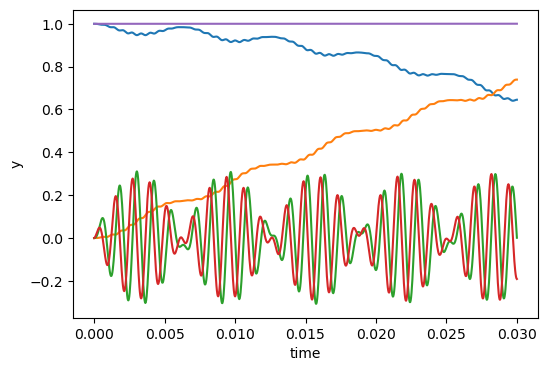

In [18]:
plt.rcParams['figure.figsize'] = [6, 4]

plt.plot(tlist, y_0r)
plt.plot(tlist, y_0i)
plt.plot(tlist, y_1r)
plt.plot(tlist, y_1i)
plt.plot(tlist, totalsum)
  
# Legend

plt.xlabel('time')
plt.ylabel('y')

plt.show()

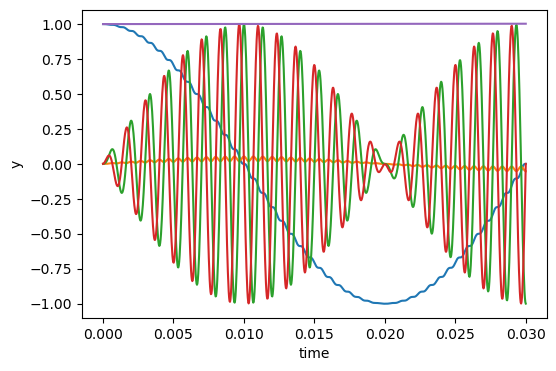

In [16]:
plt.rcParams['figure.figsize'] = [6, 4]

plt.plot(tlist, y_0r)
plt.plot(tlist, y_0i)
plt.plot(tlist, y_1r)
plt.plot(tlist, y_1i)
plt.plot(tlist, totalsum)
  
plt.xlabel('time')
plt.ylabel('y')

plt.show()